# Data Wrangling with PySpark

## Overview
Use PySpark API to gain some analytical insights on the small sparkify log dataset

In [44]:
# Imnport libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, asc, col
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import StringType, IntegerType

from pyspark.sql import Window

import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [4]:
# Read JSON (input) file
user_log = spark.read.json("./sparkify_log_small.json")

# Data Exploration 

The next cells explore the data set.

In [5]:
user_log.take(2)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000')]

In [6]:
# Use Pandas
pd.DataFrame(user_log.take(2))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Showaddywaddy,Logged In,Kenneth,M,112,Matthews,232.93342,paid,"Charlotte-Concord-Gastonia, NC-SC",PUT,NextSong,1509380319284,5132,Christmas Tears Will Fall,200,1513720872284,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",1046
1,Lily Allen,Logged In,Elizabeth,F,7,Chase,195.23873,free,"Shreveport-Bossier City, LA",PUT,NextSong,1512718541284,5027,Cheryl Tweedy,200,1513720878284,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",1000


In [7]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [9]:
pd.DataFrame(user_log.describe().collect())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,count,8347,10000,9664,9664,10000,9664,8347,10000,9664,10000,10000,9664,10000,8347,10000,10000,9664,10000
1,mean,461.0,None,None,None,19.6734,None,249.6486587492506,None,None,None,None,1.5046953695887393E12,4436.7511,Infinity,202.8984,1.5137859954164E12,None,1442.4413286423842
2,stddev,300.0,None,None,None,25.382114916132608,None,95.00437130781461,None,None,None,None,8.47314252131656E9,2043.1281541827561,NaN,18.04179115450588,3.290828862357974E7,None,829.8909432082621
3,min,!!!,Guest,Aakash,F,0,Acevedo,1.12281,free,"Aberdeen, WA",GET,About,1463503881284,9,#1,200,1513720872284,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zoie,M,163,Zuniga,1806.8371,paid,"Yuma, AZ",PUT,Upgrade,1513760702284,7144,wingless,404,1513848349284,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,999


In [13]:
pd.DataFrame(user_log.describe("artist").collect())

,0,1
0,count,8347
1,mean,461.0
2,stddev,300.0
3,min,!!!
4,max,ÃÂlafur Arnalds


In [10]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



How many entries in the table?

In [18]:
user_log.count()

10000

Show pages visited

In [19]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



What songs are played by userId= 1046?


In [20]:
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

In [11]:
# With Pandas
user_log.select(['userId','firstname','page','song']).where(user_log.userId=='1046').show(5)

+------+---------+--------+--------------------+
|userId|firstname|    page|                song|
+------+---------+--------+--------------------+
|  1046|  Kenneth|NextSong|Christmas Tears W...|
|  1046|  Kenneth|NextSong|  Be Wary Of A Woman|
|  1046|  Kenneth|NextSong|   Public Enemy No.1|
|  1046|  Kenneth|NextSong|Reign Of The Tyrants|
|  1046|  Kenneth|NextSong|      Father And Son|
+------+---------+--------+--------------------+
only showing top 5 rows



In [25]:
user_log.select(['song']).filter(user_log.userId=='1046').show(5)

+--------------------+
|                song|
+--------------------+
|Christmas Tears W...|
|  Be Wary Of A Woman|
|   Public Enemy No.1|
|Reign Of The Tyrants|
|      Father And Son|
+--------------------+
only showing top 5 rows



# Calculating Statistics by Hour

Create a function that extracts hour

In [33]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [34]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [41]:
user_log.show(2)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|  14|
|   Lily Allen|Logged In|Elizabeth|     F|            7|   Chase|195.23873| free|Shreveport-Bossie...|   PUT|NextSong|1512718541

How many songs are played per hour

In [42]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [43]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  375|
|   1|  249|
|   2|  216|
|   3|  228|
|   4|  251|
|   5|  339|
|   6|  462|
|   7|  479|
|   8|  484|
|   9|  430|
|  10|  362|
|  11|  295|
|  12|  257|
|  13|  248|
|  14|  369|
|  15|  375|
|  16|  456|
|  17|  454|
|  18|  382|
|  19|  302|
+----+-----+
only showing top 20 rows



In [44]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

Plot the songs played over time

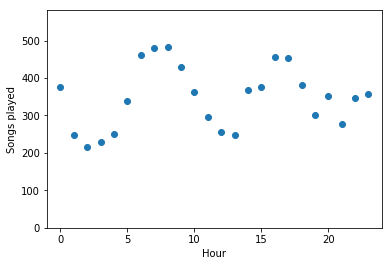

In [45]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

It turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [18]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

User counts

In [19]:
user_log_valid.count()

10000

In [20]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



How many users without userId?

In [21]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [22]:
user_log_valid.count()

9664

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [23]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+



In [24]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [25]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [26]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))


In [27]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', downgraded=0)

In [28]:
user_log.select(['userId','ts']).show(3)

+------+-------------+
|userId|           ts|
+------+-------------+
|  1046|1513720872284|
|  1000|1513720878284|
|  2219|1513720881284|
+------+-------------+
only showing top 3 rows



In [29]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [30]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [32]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").show(5)

+------+---------+-------------+--------+-----+-----+
|userId|firstname|           ts|    page|level|phase|
+------+---------+-------------+--------+-----+-----+
|  1138|    Kelly|1513729066284|NextSong| paid|    1|
|  1138|    Kelly|1513729066284|    Home| paid|    1|
|  1138|    Kelly|1513729313284|NextSong| paid|    1|
|  1138|    Kelly|1513729552284|NextSong| paid|    1|
|  1138|    Kelly|1513729783284|NextSong| paid|    1|
+------+---------+-------------+--------+-----+-----+
only showing top 5 rows



Which page did user id "" (empty string) NOT visit?

In [35]:
data = user_log

In [37]:
# User with blank userId
blankpages = data.filter(data.userId=="").select(['page']).dropDuplicates()

# get possible pages that could be visited
allpages = data.select('page').dropDuplicates()

for row in set(allpages.collect()) - set(blankpages.collect()):
    print(row.page)

Upgrade
Logout
Settings
Submit Downgrade
Downgrade
NextSong
Submit Upgrade
Save Settings
Error


What type of user does the empty string user id most likely refer to?

In [38]:
data.filter(data.userId!="") \
    .select(['auth','itemInSession','length','level','method','page','registration','status']) \
    .dropDuplicates() \
    .show()

+---------+-------------+---------+-----+------+--------+-------------+------+
|     auth|itemInSession|   length|level|method|    page| registration|status|
+---------+-------------+---------+-----+------+--------+-------------+------+
|Logged In|            1|240.50893| free|   PUT|NextSong|1500151042284|   200|
|Logged In|            0|     null| free|   GET|    Home|1507496389284|   200|
|Logged In|            7|201.79546| free|   PUT|NextSong|1504267154284|   200|
|Logged In|           11|229.98159| paid|   PUT|NextSong|1489899558284|   200|
|Logged In|            0|     null| free|   GET|    Home|1509340135284|   200|
|Logged In|           21|262.79138| paid|   PUT|NextSong|1494799164284|   200|
|Logged In|           26| 275.1473| paid|   PUT|NextSong|1509038679284|   200|
|Logged In|           94|186.87955| paid|   PUT|NextSong|1512172030284|   200|
|Logged In|            0|     null| free|   GET|    Home|1508374052284|   200|
|Logged In|            0|232.28036| free|   PUT|Next

How many female users do we have in the data set?

In [39]:
data.filter(data.gender=='F').select(['userId', 'gender']).dropDuplicates().count()

462

How many songs were played from the most played artist?

In [40]:
data.filter(data.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show()

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|            Coldplay|         83|
|       Kings Of Leon|         69|
|Florence + The Ma...|         52|
|            BjÃÂ¶rk|         46|
|       Dwight Yoakam|         45|
|       Justin Bieber|         43|
|      The Black Keys|         40|
|         OneRepublic|         37|
|        Jack Johnson|         36|
|                Muse|         36|
|           Radiohead|         31|
|        Taylor Swift|         29|
|          Lily Allen|         28|
|Barry Tuckwell/Ac...|         28|
|               Train|         28|
|           Metallica|         27|
|           Daft Punk|         27|
|          Nickelback|         27|
|          Kanye West|         26|
|Red Hot Chili Pep...|         24|
+--------------------+-----------+
only showing top 20 rows



How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.


In [45]:
function = udf(lambda ishome: int(ishome == 'Home'), IntegerType())
user_window = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

# Get count of visit periods
cusum = data.filter((data.page== 'NextSong') | (data.page== 'Home')) \
            .select('userID', 'page','ts') \
            .withColumn('homevisit', function(col('page'))) \
            .withColumn('period', Fsum('homevisit').over(user_window))
cusum.show(10)

+------+--------+-------------+---------+------+
|userID|    page|           ts|homevisit|period|
+------+--------+-------------+---------+------+
|  1436|NextSong|1513783259284|        0|     0|
|  1436|NextSong|1513782858284|        0|     0|
|  2088|    Home|1513805972284|        1|     1|
|  2088|NextSong|1513805859284|        0|     1|
|  2088|NextSong|1513805494284|        0|     1|
|  2088|NextSong|1513805065284|        0|     1|
|  2088|NextSong|1513804786284|        0|     1|
|  2088|NextSong|1513804555284|        0|     1|
|  2088|NextSong|1513804196284|        0|     1|
|  2088|NextSong|1513803967284|        0|     1|
+------+--------+-------------+---------+------+
only showing top 10 rows



In [46]:
cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID','period') \
    .agg({'period':'count'}).show(10)


+------+------+-------------+
|userID|period|count(period)|
+------+------+-------------+
|  1436|     0|            2|
|  2088|     1|           13|
|  2162|     0|           19|
|  2162|     2|           15|
|  2294|     0|            4|
|  2294|     1|           17|
|  2294|     2|            3|
|  2294|     3|           16|
|  2294|     4|            4|
|  2294|     5|           11|
+------+------+-------------+
only showing top 10 rows



In [47]:
cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID','period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 6.898347107438017|
+------------------+

